## Energy Innovation MCOE Compilation

- <a href=#setup>Setup</a>
- <a href=#data_out>Data Outputs</a>
    * <a href=#final-plant>Plant Level Output</a>
    * <a href=#final-unit>Unit Level Output</a>
    * <a href=#src-tbl>Source Table</a>
- <a href=#data_comp>Data Components</a>
    * <a href=#part1>Part 1: Basic Plant & Unit Information</a>
    * <a href=#part2>Part 2: Cost Data</a>
    * <a href=#part3>Part 3: Emissions & Public Health Data</a>
- <a href=#data_val>Data Validation</a>
    * <a href=#ferc-v-eia>FERC Form 1 vs. EIA</a>

-------------

## <a id='setup'>Setup</a>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pudl
import sqlalchemy as sa
from ei_mcoe import *
import sys
import os
import matplotlib.pyplot as plt
import logging

In [3]:
# basic setup for logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler(stream=sys.stdout)
formatter = logging.Formatter('%(message)s')
handler.setFormatter(formatter)
logger.handlers = [handler]
pd.options.display.max_columns = None

In [4]:
pudl_settings = pudl.workspace.setup.get_defaults()
pudl_engine = sa.create_engine(pudl_settings["pudl_db"])

In [5]:
pudl_out = pudl.output.pudltabl.PudlTabl(pudl_engine, freq='AS', rolling=True)

-------------

## <a id='data_out'>Data Outputs</a>

In [6]:
cems_df = get_cems()

Getting CEMS data....this may take a sec.


/Users/aesharpe/miniconda3/envs/pudl-dev/lib/python3.8/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


### <a id='final-plant'>Plant Level Output</a>

In [7]:
 plant = main(pudl_out, cems_df, 'plant-fuel') # add_sources=True

Prepping raw EIA data
filling in fuel cost NaNs with rolling averages
Converting date to year
Calculating generator age
Converting date to year
Building Part 1 output
 - Checking EIA aggregation for plants with different                 qualitative data
[69, 136, 219, 652] have internal differences in plant_name_eia
[69] have internal differences in state
[69, 219] have internal differences in city
[69, 136, 219] have internal differences in latitude
[69, 136, 219, 652] have internal differences in longitude
 - Calculating weighted average for generator_age_years
 - Calculating weighted average for heat_rate_mmbtu_mwh
Finished compiling Part 1 plant-fuel level data
Cleaning Part 1 Output
Finished cleaning Part 1 data
Building Part 3 output
Building Part 1 output
 - Checking EIA aggregation for plants with different                 qualitative data
[69, 136, 219, 652] have internal differences in plant_name_eia
[69] have internal differences in state
[69, 219] have internal differences 

<ipython-input-7-f47ce45b8d05>:1: DtypeWarning: Columns (57,58) have mixed types.Specify dtype option on import or set low_memory=False.
  plant = main(pudl_out, cems_df, 'plant-fuel') # add_sources=True


On average, NEMS values are
 - Comparing heat rates internally
Building Part 1 output
 - Checking EIA aggregation for plants with different                 qualitative data
 - Calculating weighted average for generator_age_years
 - Calculating weighted average for heat_rate_mmbtu_mwh
Finished compiling Part 1 unit-fuel level data
average heat rates for fuel types: {'coal': 12.02, 'gas': 15.89, 'oil': 12.51, 'waste': 18.24}
standard deviation for fuel types: {'coal': 22.75, 'gas': 139.02, 'oil': 5.18, 'waste': 4.47}
preparing merge: checking df length compatability
Finished compiling Part 2 data compilation
Cleaning Part 2 output
Finished cleaning Part 2 data
Making it look pretty...
Finished compiling all parts!


In [10]:
#test_segment(plant)

,EIA Plant Code,PUDL Plant Code,Plant Name,Report Year,EIA Generator ID,MW Nameplate Capacity,Age,Retirement Date,Broad Fuel Classification,Technology,Annual Total Fuel Consumption MMBtu,Annual Electricity Net Generation MWh,Heat Rate MMBtu/MWh,Significant Heat Rate Discrepancy?,Fuel Cost,Variable O&M,Fixed O&M,Variable O&M used NEMS?,Fixed O&M used NEMS?,Marginal Cost of Energy,Annual CO2 Emissions tons,Annual NOx Emissions tons,Annual SO2 Emissions tons,Annual PM2.5 Emissions tons,Annual Public Health Damages,Annual Premature Dealths,Latitude,Longitude,State,City
97,[3],32,Barry,2017,4; 5,1192.5,46.68,NaN,coal,BIT,34633362.63,3432862.0,10.09,False,1.005353e+08,9.21,276.12,False,False,329311.56,3760363.0,2282.760010,4197.810059,734.63,1.060919e+09,143.4,31.01,-88.01,AL,Bucks
100,[3],32,Barry,2017,1; 2; A1CT; A1CT2; A1ST; A2C1; A2C2; A2ST,1377.0,27.23,NaN,gas,NG,59012121.06,8431692.0,7.00,False,1.973655e+08,9.21,129.81,False,False,178783.80,10695620.0,751.070007,56.240002,6028.66,4.157845e+09,561.9,31.01,-88.01,AL,Bucks
96,[3],32,Barry,2016,4; 5,1192.5,45.68,NaN,coal,BIT,43723130.75,4357881.0,10.03,False,1.459468e+08,7.35,235.28,False,False,280609.77,4664941.0,3848.689941,5400.430176,932.59,1.353085e+09,182.8,31.01,-88.01,AL,Bucks
99,[3],32,Barry,2016,A1CT; A1CT2; A1ST; A2C1; A2C2; A2ST,1070.8,16.00,NaN,gas,NG,58685906.27,8401360.0,6.99,False,1.689625e+08,7.35,109.59,False,False,117372.65,10646078.0,725.409973,53.740002,6006.97,4.069781e+09,550.0,31.01,-88.01,AL,Bucks
95,[3],32,Barry,2015,3; 4; 5,1464.5,46.78,NaN,coal,BIT,46389577.23,4605304.0,10.07,False,1.529463e+08,8.76,221.20,False,False,323988.78,5035628.5,5450.919922,8658.570312,985.54,1.777700e+09,240.2,31.01,-88.01,AL,Bucks
98,[3],32,Barry,2015,2; A1CT; A1CT2; A1ST; A2C1; A2C2; A2ST,1223.9,20.75,NaN,gas,NG,48074820.32,6783671.0,7.09,True,1.511159e+08,8.76,125.50,False,False,153627.19,8779124.0,600.059998,51.759998,4850.32,3.229046e+09,436.4,31.01,-88.01,AL,Bucks
94,[3],32,Barry,2013,4,403.7,44.00,NaN,coal,BIT,17146399.37,1675131.0,10.24,False,7.982038e+07,41.81,1022.05,False,False,412691.88,2148602.5,3069.100098,10042.639648,358.48,1.451878e+09,196.2,31.01,-88.01,AL,Bucks
93,[3],32,Barry,2012,1; 2; 3; 4; 5,1770.7,46.24,NaN,coal,BIT,54584014.82,5319147.0,10.26,False,2.563137e+08,13.28,321.89,False,False,570031.21,5992011.0,5222.990234,10713.469727,1138.30,2.057757e+09,278.1,31.01,-88.01,AL,Bucks
92,[3],32,Barry,2011,1; 2; 3; 4; 5,1770.7,45.24,NaN,coal,BIT,48392089.04,4653772.0,10.40,False,2.078740e+08,18.22,360.96,False,False,639213.04,4943643.5,5981.600098,11621.389648,995.91,2.053610e+09,277.5,31.01,-88.01,AL,Bucks


### <a id='final-unit'>Unit Level Output</a>

In [8]:
unit = main(pudl_out, cems_df, 'unit-fuel')

Prepping raw EIA data
Converting date to year
Calculating generator age
Converting date to year
Building Part 1 output
 - Checking EIA aggregation for plants with different                 qualitative data
 - Calculating weighted average for generator_age_years
 - Calculating weighted average for heat_rate_mmbtu_mwh
Finished compiling Part 1 unit-fuel level data
Cleaning Part 1 Output
Finished cleaning Part 1 data
Building Part 3 output
Building Part 1 output
 - Checking EIA aggregation for plants with different                 qualitative data
 - Calculating weighted average for generator_age_years
 - Calculating weighted average for heat_rate_mmbtu_mwh
Finished compiling Part 1 unit-fuel level data
 - Adding cems to EIA data
 - Adding pm values to the dataframe
 -- Calculating tech percents
 -- Calculating pm2.5 values
 - Calculating public health damages from emissions
 - Calculating the amount of premature deaths
Finished building Part 3 unit-fuel level data
Cleaning Part 3 output


In [58]:
#t = test_segment(unit)
#year_selector(t, [2012, 2013])

### <a id='src-tbl'>Source Table</a>

In [9]:
generate_source_df()

Generating separate source dataframe


,Columns,Source,Description
0,EIA Plant Code,EIA860,table 2 or 3.1
1,PUDL Plant Code,PUDL,
2,Plant Name,EIA860,table 2
3,PUDL Unit ID,PUDL,maps onto EIA plant code
4,Report Year,EIA860,table X; adapted from report_date for FERC For...
5,Latitude,EIA860,table 2
6,Longitude,EIA860,table 2
7,State,EIA860,table 2
8,City,EIA860,table 2
9,EIA Generator ID,EIA860,table 3.1


-------------------------

## <a id='data_comp'>Data Components</a>

### <a id='part1'>Part 1: Plant & Unit Level Data</a>
EIA-860 and EIA-923 generator-level data is aggregated by either plant or unit and subdivided by broad fuel type (coal, gas, oil, waste). 
[`Age`] is calculated by finding the weighted average (capacity as weight) of the generators in a given aggregation. 
[`Heat Rate`] is also calculated by weighted average (this time with net generation as weight). 
[`MW Nameplate Capacity`] and [`Annual Electricity Net Generation MWh`] at a given level of aggregation are calculated by summing generator-level data. 

For purely qualitative information (just plant name and location) add [`drop_calcs=True`] to the parameters.

### <a id='part2'>Part 2: Cost Data</a>

Cost and generation data from EIA-860, EIA-923, and FERC Form 1 are subdivided by plant and broad fuel type. The fuel-type breakdown for FERC Form 1 plants is determined by the EIA fuel breakdown for plants of the same PUDL Plant Code. For missing fixed and variable costs from 2018, we've input data from NEMS as a subsitutde. MCOE is calculated using data from the following sources:

##### MCOE Variable Origins (as named in original database)
- Fuel cost = **EIA-923**: [`total_fuel_cost`]
- MW Capacity = **EIA-860**: [`capacity_mw`]
- Net MWh Generated = **EIA-923**: [`net_generation_mwh`]
- Variable O&M = **FERC Form 1**: [`opex_production_total`] - [`opex_fuel`]
- Fixed O&M = **FERC Form 1**: [`capex_total`]

##### Data Flags
[`Significant Heat Rate Discrepancy`] - a field indicating whether a plant fuel type contains units that have outlier heatrates. If a unit is more than one standard deviation away from the mean value for units of its same fuel type rate, the field will appear [`True`].

[`Fixed/Variable O&M used NEMS?`] - a field indicating whether the given row used FERC Form 1 cost data or NEMS cost data. If NEMS were used, the field will appear [`True`].

[`Count`].

### <a id='part3'>Part 3: Emissions & Public Health Data</a>

CEMS, or Continuous Emission Monitoring Systems, provide detailed information about gas, particulate matter and other pollutants that emanate from various point sources. Here, CEMS data on co2, so2, and nox emissions from generation units is combined with EIA plant data at the plant and unit level, separated by fuel type. 

Data on PM2.5 emissions comes from Argonne National Laboratory's GREET Model. The model's Electricity Generation Module table 2.1 contains PM2.5 emissions data in g/kwh at the grandularity of NERC region and technology type. The PM2.5 emissions data are mapped onto EIA and CEMS data by creating buckets of the same granularity.



--------------

## <a id='data_val'>Data Validation</a>

### <a id='ferc-v-eia'>FERC Form 1 vs. EIA</a>

The first test looks at the **validity of using EIA fuel percentage values to disaggregate FERC Form 1 data by fuel type.** 


The following hisograms compare the fuel fractions available in FERC Form 1 with the fuel fractions created by aggregating EIA data by plant and fuel type. The cost factors used in the calculation of MCOE rely on FERC Form 1 fixed and operating cost data broken down by plant and fuel type based on EIA fuel breakdown. To ensure that there is a degree of similarity between the percent breakdown of EIA fuel break down and FERC Form 1 breakdown, this histogram depicts the EIA percent / FERC Form 1 percent. FERC Form 1 has two fuel breakdowns, by MMBtu and by cost. The graph to the left divides EIA percents by FERC Form 1 MMBtu fuel fractions and on the right by cost fractions. The closer the value to 1, the more acurate the comparison.

Converting date to year
 - Readying EIA fuel pct data to merge with FERC
 - Building eia table broken down by plant and fuel type
 -- Calculating eia fuel type percentages
Turning eia fuel percent values for net_generation_mwh into columns
Turning eia fuel percent values for capacity_mw into columns


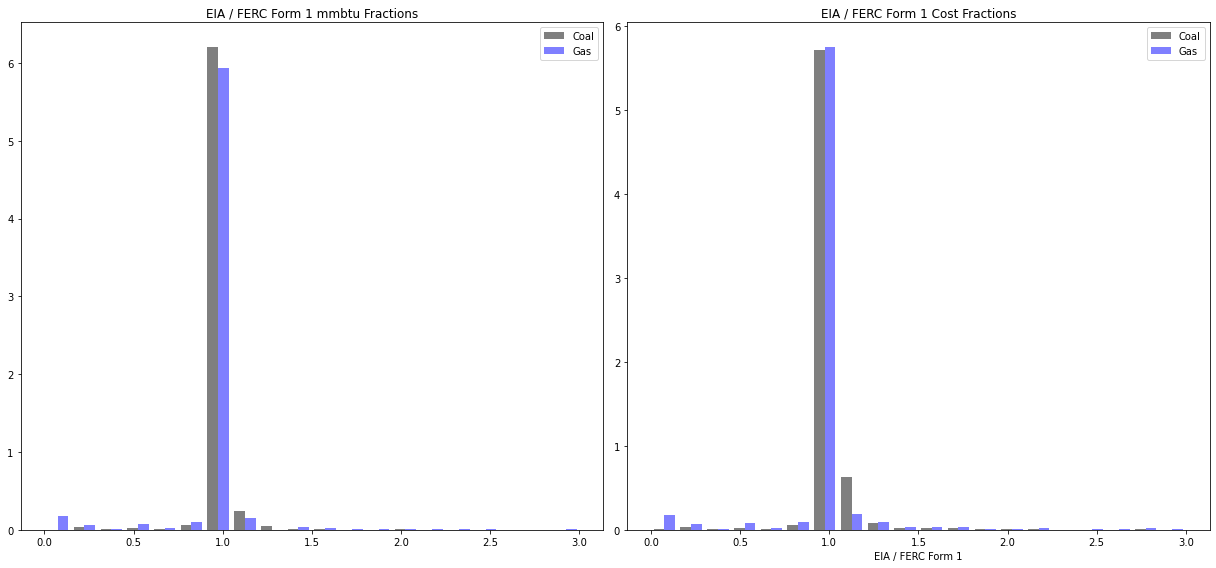

In [11]:
plot_fuel_pct_check(merge_ferc1_eia_fuel_pcts(pudl_out))

As we know, FERC Form 1 and EIA data don't always match up properly. The following graphs depict **the difference in FERC Form 1 and EIA-860/923 reporting on the these particular values:** [`capacity_mw`], [`opex_fuel`], [`total_mmbtu`], [`net_generation_mwh`], [`capacity_factor`], [`heat_rate_mmbtu_mwh`], [`fuel_cost_per_mwh`], [`fuel_cost_per_mmbtu`], used in the calculation of MCOE.

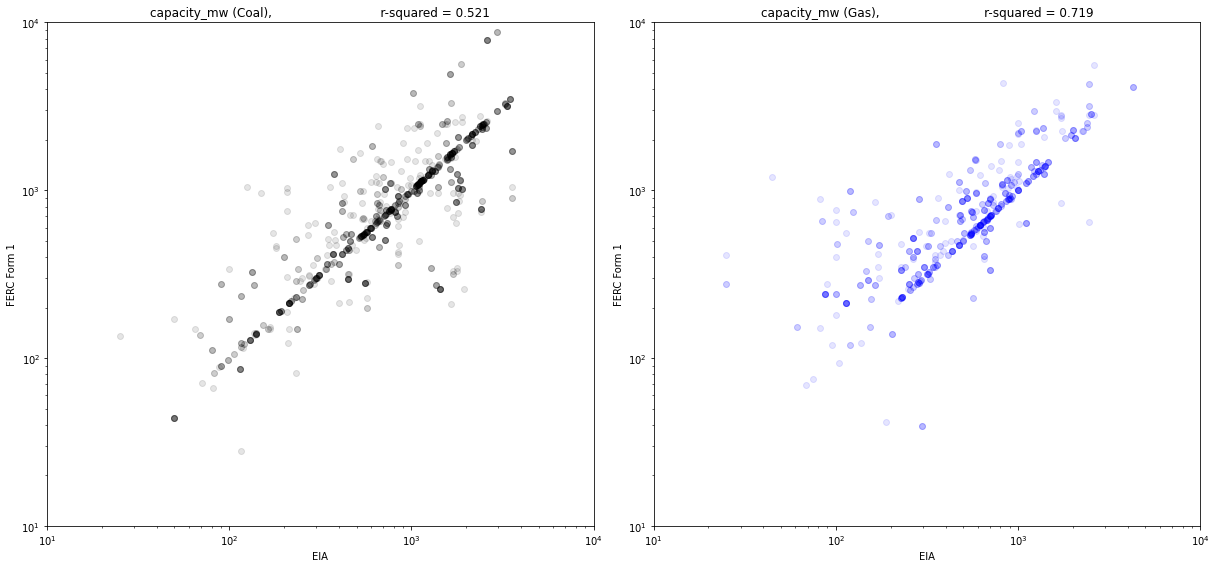

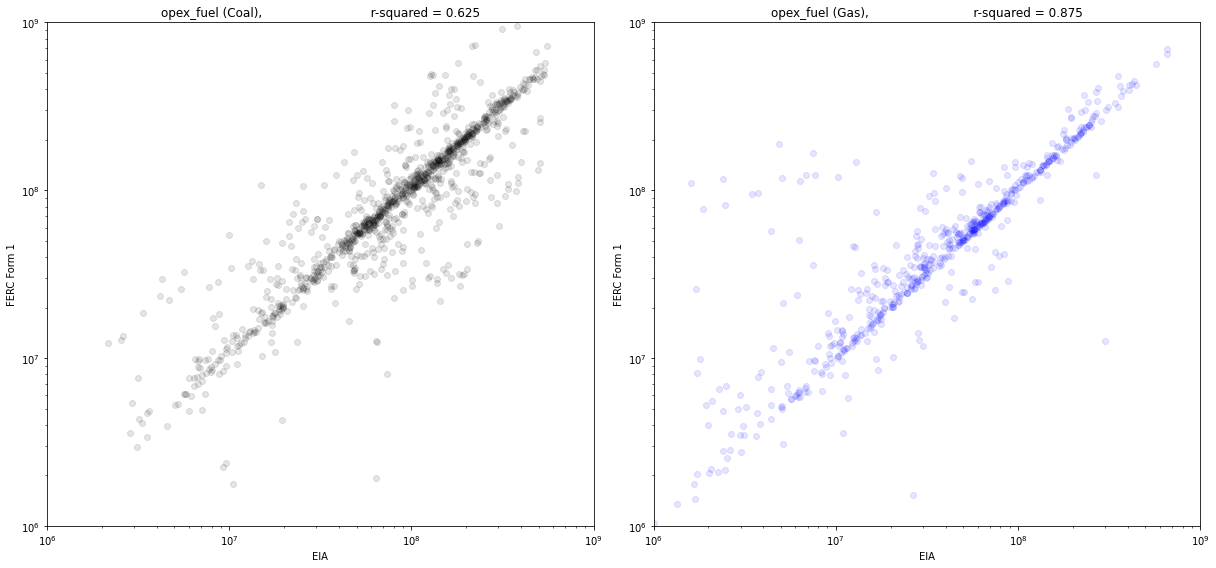

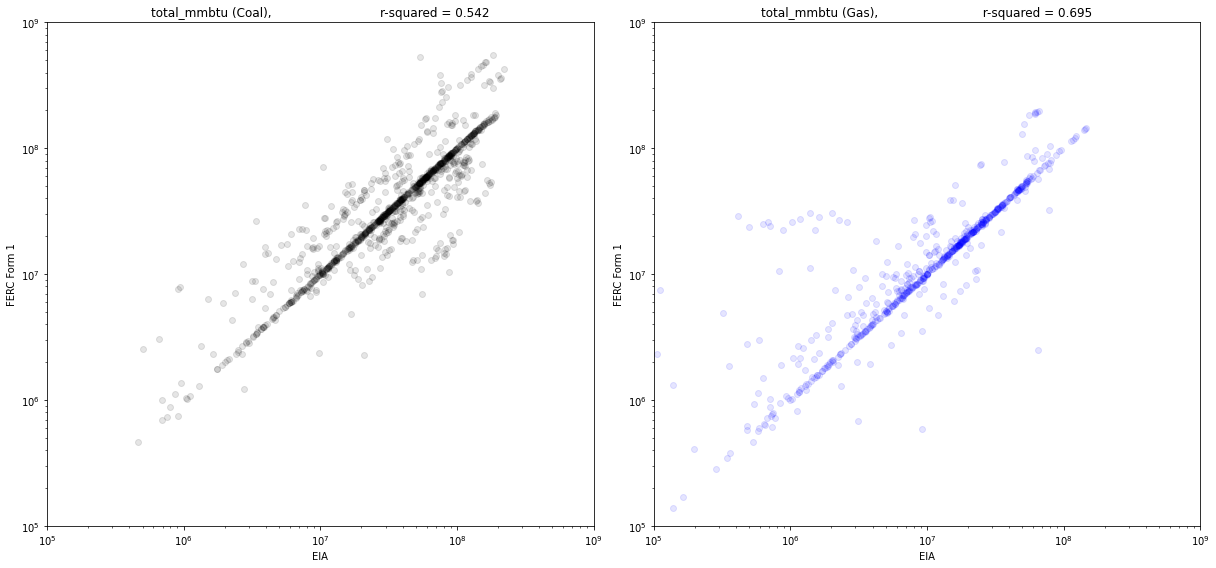

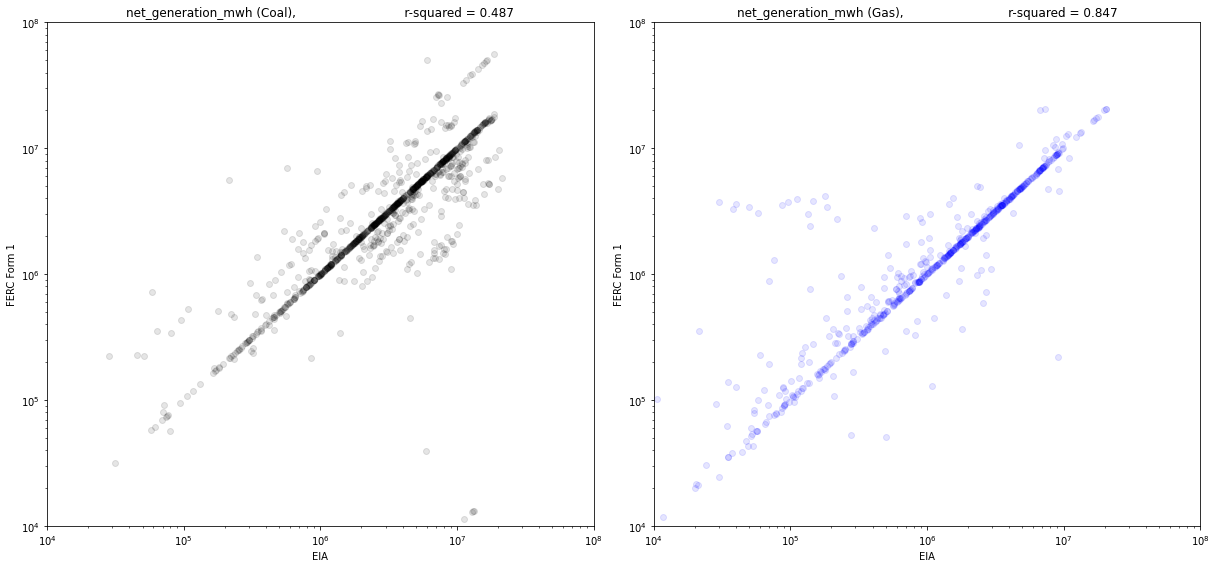

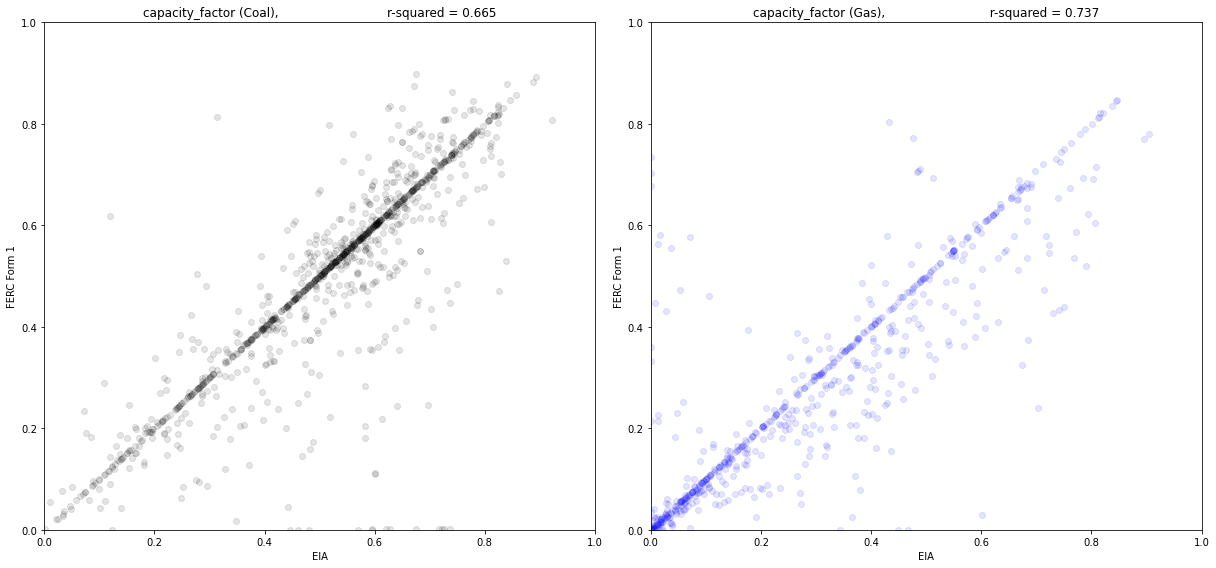

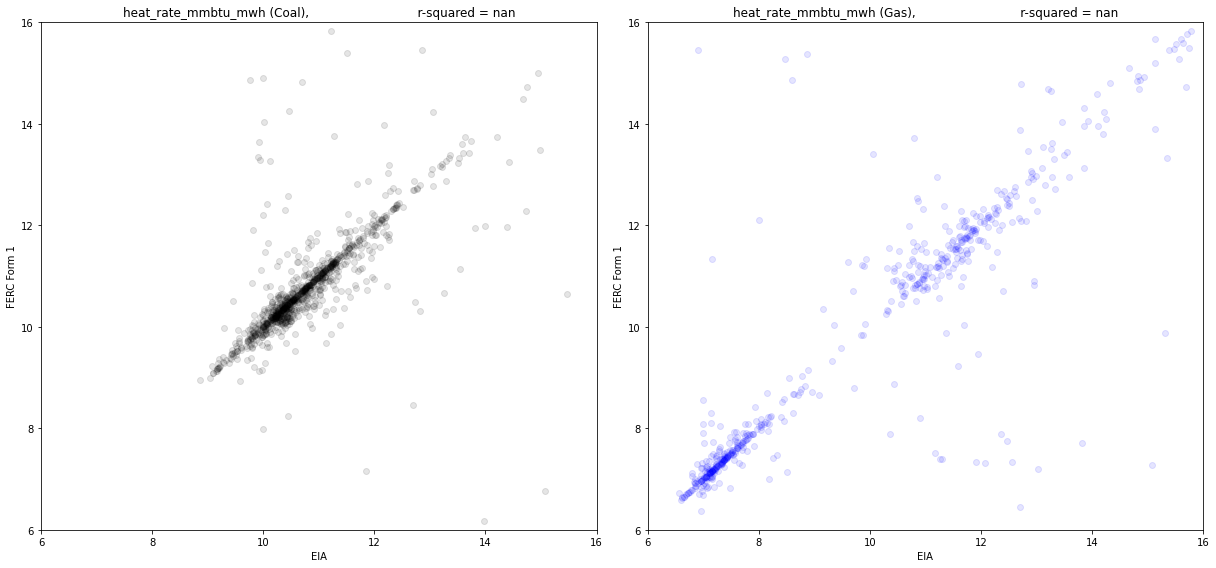

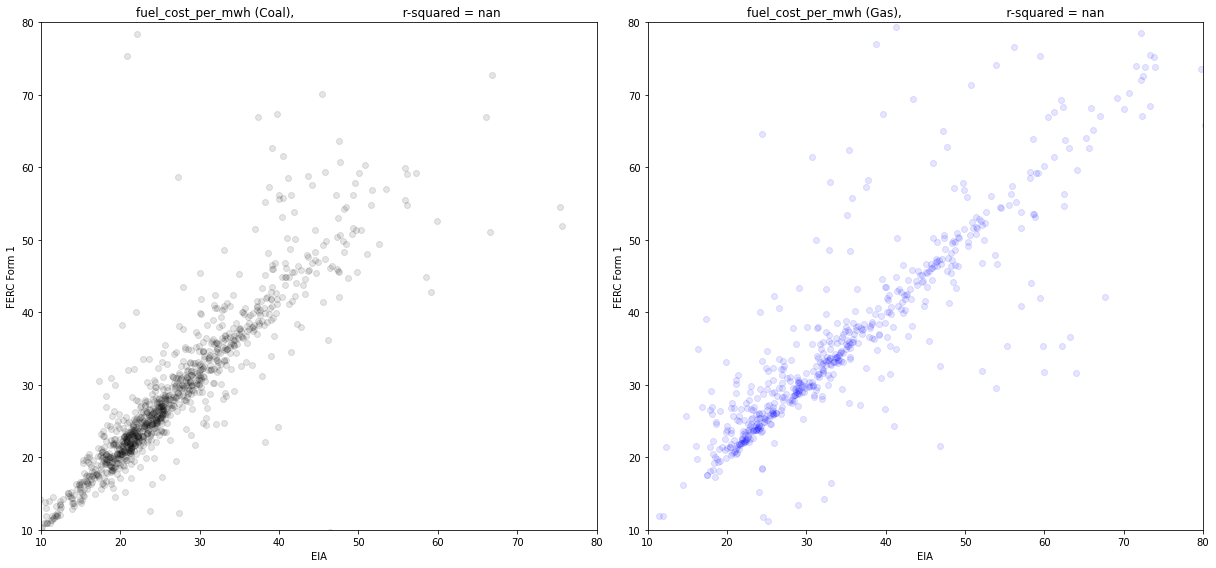

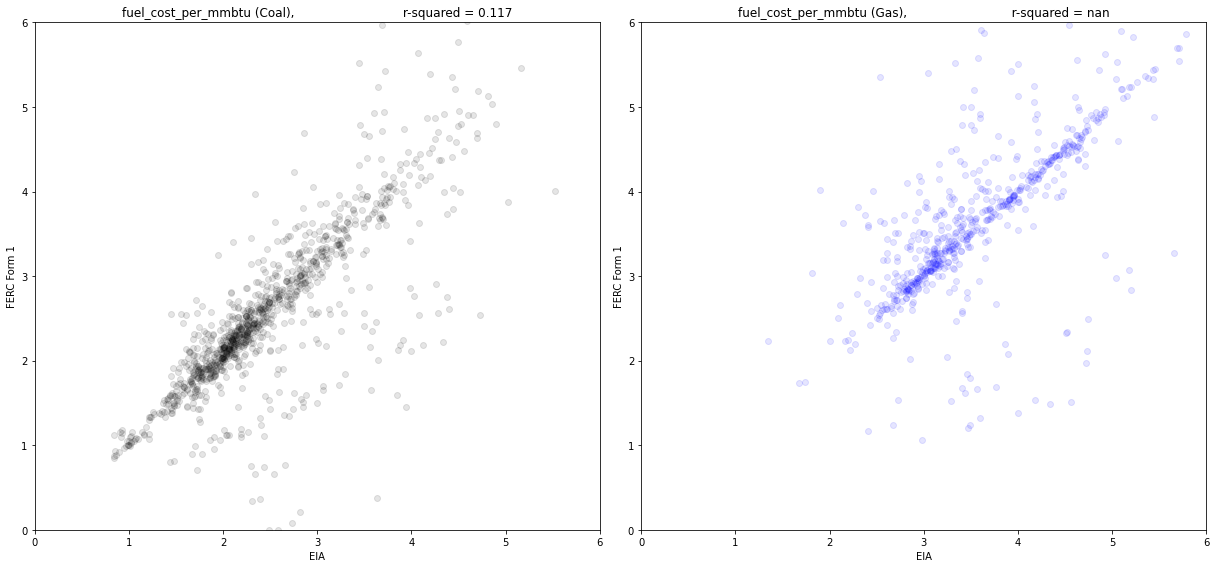

In [14]:
plot_eia_v_ferc(pudl_out)

### <a id='heatrate'>Heat Rate Comparison</a>

Prepping raw EIA data
Converting date to year
Calculating generator age
 - Comparing heat rates internally
Building Part 1 output
 - Checking EIA aggregation for plants with different                 qualitative data
 - Calculating weighted average for generator_age_years
 - Calculating weighted average for heat_rate_mmbtu_mwh
Finished compiling Part 1 unit-fuel level data
average heat rates for fuel types: {'coal': 12.02, 'gas': 15.89, 'oil': 12.51, 'waste': 18.24}
standard deviation for fuel types: {'coal': 22.75, 'gas': 139.02, 'oil': 5.18, 'waste': 4.47}


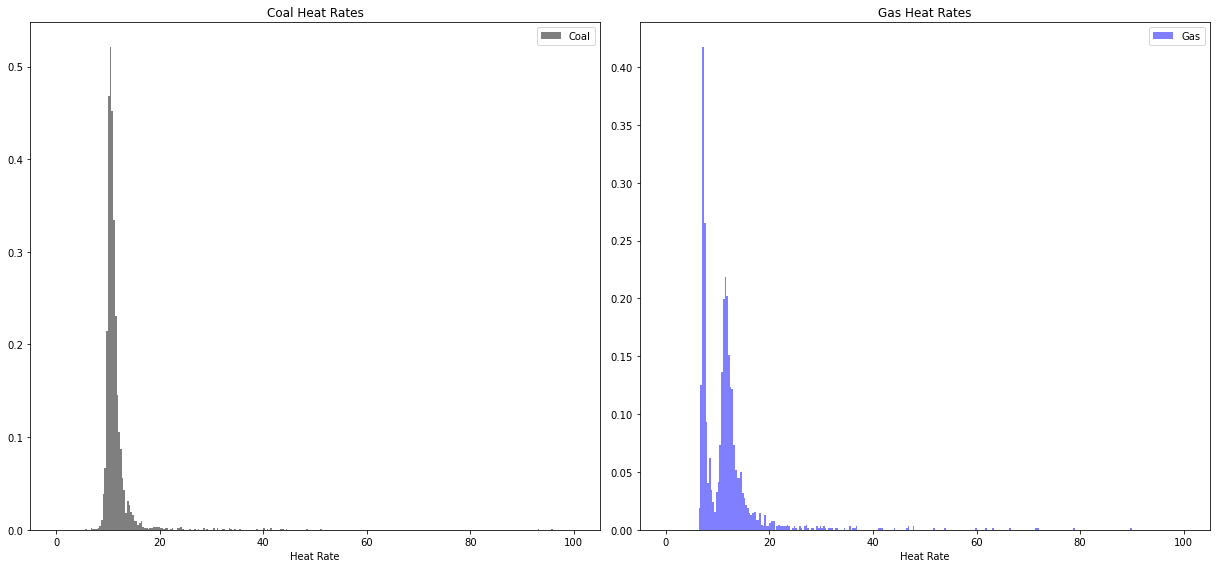

In [15]:
plot_heat_rate(pudl_out)